In [3]:
import os
import random
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [4]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch Version: {torch.__version__}")

Is CUDA available: False
PyTorch Version: 1.10.0+cpu


In [25]:
dataset_path = os.path.abspath("dataset")

transforms = tt.Compose([tt.Resize((256, 256)),
                        tt.ColorJitter(brightness=0.3, hue=0.1),
                        tt.RandomPerspective(distortion_scale=0.5, p=1.0),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])

train_dataset = ImageFolder(os.path.join(dataset_path, "Train"), transforms)
test_dataset = ImageFolder(os.path.join(dataset_path, "Test"), transforms)
validation_dataset = ImageFolder(os.path.join(dataset_path, "Validation"), transforms)

In [26]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, num_workers=0)

In [27]:
label_map = {0: "mask", 1: "no_mask"}

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)

        for (image, label, axs) in zip(images, labels, axs.flatten()):
            axs.imshow(image.permute(1,2,0).clamp(0,1))
            axs.set_title(label_map[label.item()])
            axs.axis('off')
        
        break

    plt.show()

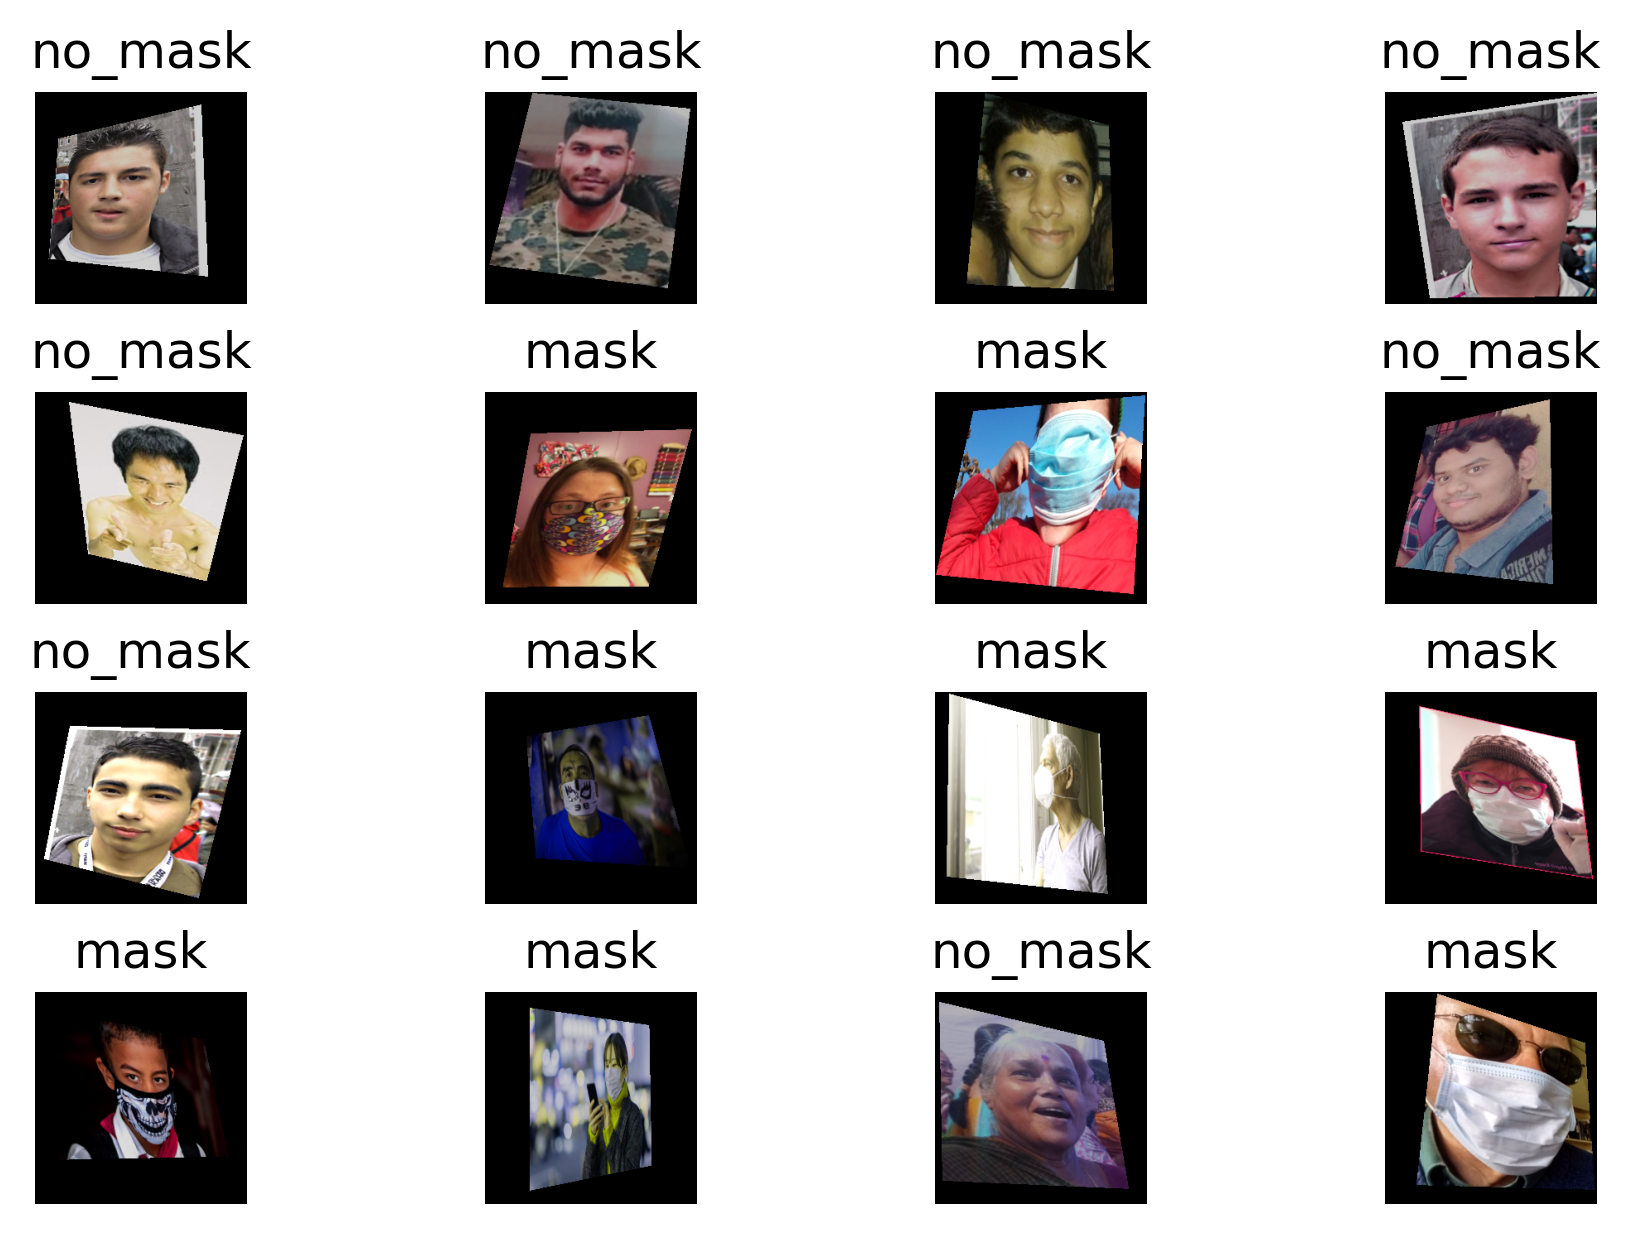

In [28]:
show_batch(train_dataloader)

In [8]:
for images, labels in test_dataloader:
    print(f"Shape of images [N, C, H, W]: {images.shape}")
    print(f"Shape of labels: {labels.shape}, {labels.dtype}")
    break

Shape of images [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of labels: torch.Size([16]), torch.int64


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [10]:
from cnn_model import mask_net

model = mask_net(in_channels=3, num_classes=2).to(device)
print(model)

mask_net(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [82]:
epochs = 50

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 0.803946  [    0/  600]
loss: 0.338314  [  160/  600]
loss: 0.188508  [  320/  600]
loss: 0.194743  [  480/  600]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.371958 

Epoch 2
-------------------------------
loss: 0.342611  [    0/  600]
loss: 0.102045  [  160/  600]
loss: 0.117763  [  320/  600]
loss: 0.167677  [  480/  600]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.169286 

Epoch 3
-------------------------------
loss: 0.092204  [    0/  600]
loss: 0.435652  [  160/  600]
loss: 0.097103  [  320/  600]
loss: 0.075302  [  480/  600]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.174033 

Epoch 4
-------------------------------
loss: 0.043248  [    0/  600]
loss: 0.137583  [  160/  600]
loss: 0.042534  [  320/  600]
loss: 0.151940  [  480/  600]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.159437 

Epoch 5
-------------------------------
loss: 0.110640  [    0/  600]
loss: 0.015061  [  160/  600]
loss: 0.027528  [  320/  600]
loss: 0.029410  [  480

In [49]:
# torch.save(model.state_dict(), "model.pth")
# print("Saved net model state to model.pth")

Saved CNN_net model state to model.pth


In [25]:
model = mask_net(in_channels=3, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(torch.load("model.pth", map_location=device))
model.load_state_dict(torch.load("model.pth", map_location=device))

OrderedDict([('conv1.0.weight', tensor([[[[-0.0166,  0.1552,  0.1816],
          [-0.0334, -0.1594,  0.0624],
          [ 0.0858, -0.1461,  0.0268]],

         [[-0.0745, -0.1636, -0.0323],
          [ 0.1840,  0.0004, -0.1819],
          [-0.1739, -0.1754, -0.0005]],

         [[ 0.0862, -0.0097,  0.0890],
          [-0.0845,  0.0109,  0.1669],
          [ 0.0822, -0.0921, -0.0240]]],


        [[[-0.0258, -0.1792,  0.0729],
          [-0.1415, -0.0618, -0.0456],
          [ 0.0506, -0.0946,  0.0733]],

         [[-0.0174, -0.0362,  0.0861],
          [-0.0525,  0.1561,  0.0667],
          [ 0.0403,  0.0448, -0.1655]],

         [[-0.0256,  0.1455, -0.0403],
          [ 0.1372, -0.0965,  0.1514],
          [-0.0783, -0.1313,  0.1106]]],


        [[[-0.1835, -0.0691, -0.0575],
          [ 0.0815,  0.0435, -0.0528],
          [ 0.1492, -0.0719,  0.1337]],

         [[-0.0938, -0.0979,  0.1405],
          [-0.0389, -0.0872, -0.1434],
          [ 0.0539, -0.1160,  0.1916]],

         [[-

RuntimeError: Error(s) in loading state_dict for mask_net:
	Unexpected key(s) in state_dict: "res2.0.weight", "res2.0.bias", "res2.1.weight", "res2.1.bias", "res2.1.running_mean", "res2.1.running_var", "res2.1.num_batches_tracked", "conv4.0.weight", "conv4.0.bias", "conv4.1.weight", "conv4.1.bias", "conv4.1.running_mean", "conv4.1.running_var", "conv4.1.num_batches_tracked". 
	size mismatch for res1.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 16, 3, 3]).
	size mismatch for res1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for res1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for res1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for res1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for res1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv2.0.weight: copying a param with shape torch.Size([128, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for classifier.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for classifier.2.weight: copying a param with shape torch.Size([2, 128]) from checkpoint, the shape in current model is torch.Size([2, 512]).

In [16]:
def predict(tensor, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    prediction = model(tensor.unsqueeze(0))
    prediction = prediction.clone().detach()
    return prediction

In [17]:
classes = ["mask", "no_mask"]

model.eval()

rand_number = random.randint(0, len(validation_dataset))
x, y = validation_dataset[rand_number][0], validation_dataset[rand_number][1]

with torch.no_grad():
    pred = predict(x, model)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: \"{predicted}\", Actual: \"{actual}\"")

RuntimeError: Given input size: (256x4x4). Calculated output size: (256x0x0). Output size is too small

In [18]:
classes = ["mask", "no_mask"]

def show_validation(images, labels):
    fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)
    
    for (image, label, axs) in zip(images, labels, axs.flatten()):
        axs.imshow(image.permute(1,2,0).clamp(0,1))
        
        with torch.no_grad():
            pred = predict(image, model)
            predicted, actual = classes[pred[0].argmax(0)], classes[label]
            axs.set_title(f"net:{predicted},\nirl: {actual}", fontsize=10)
        
        axs.axis('off')

    plt.show()

RuntimeError: Given input size: (256x4x4). Calculated output size: (256x0x0). Output size is too small

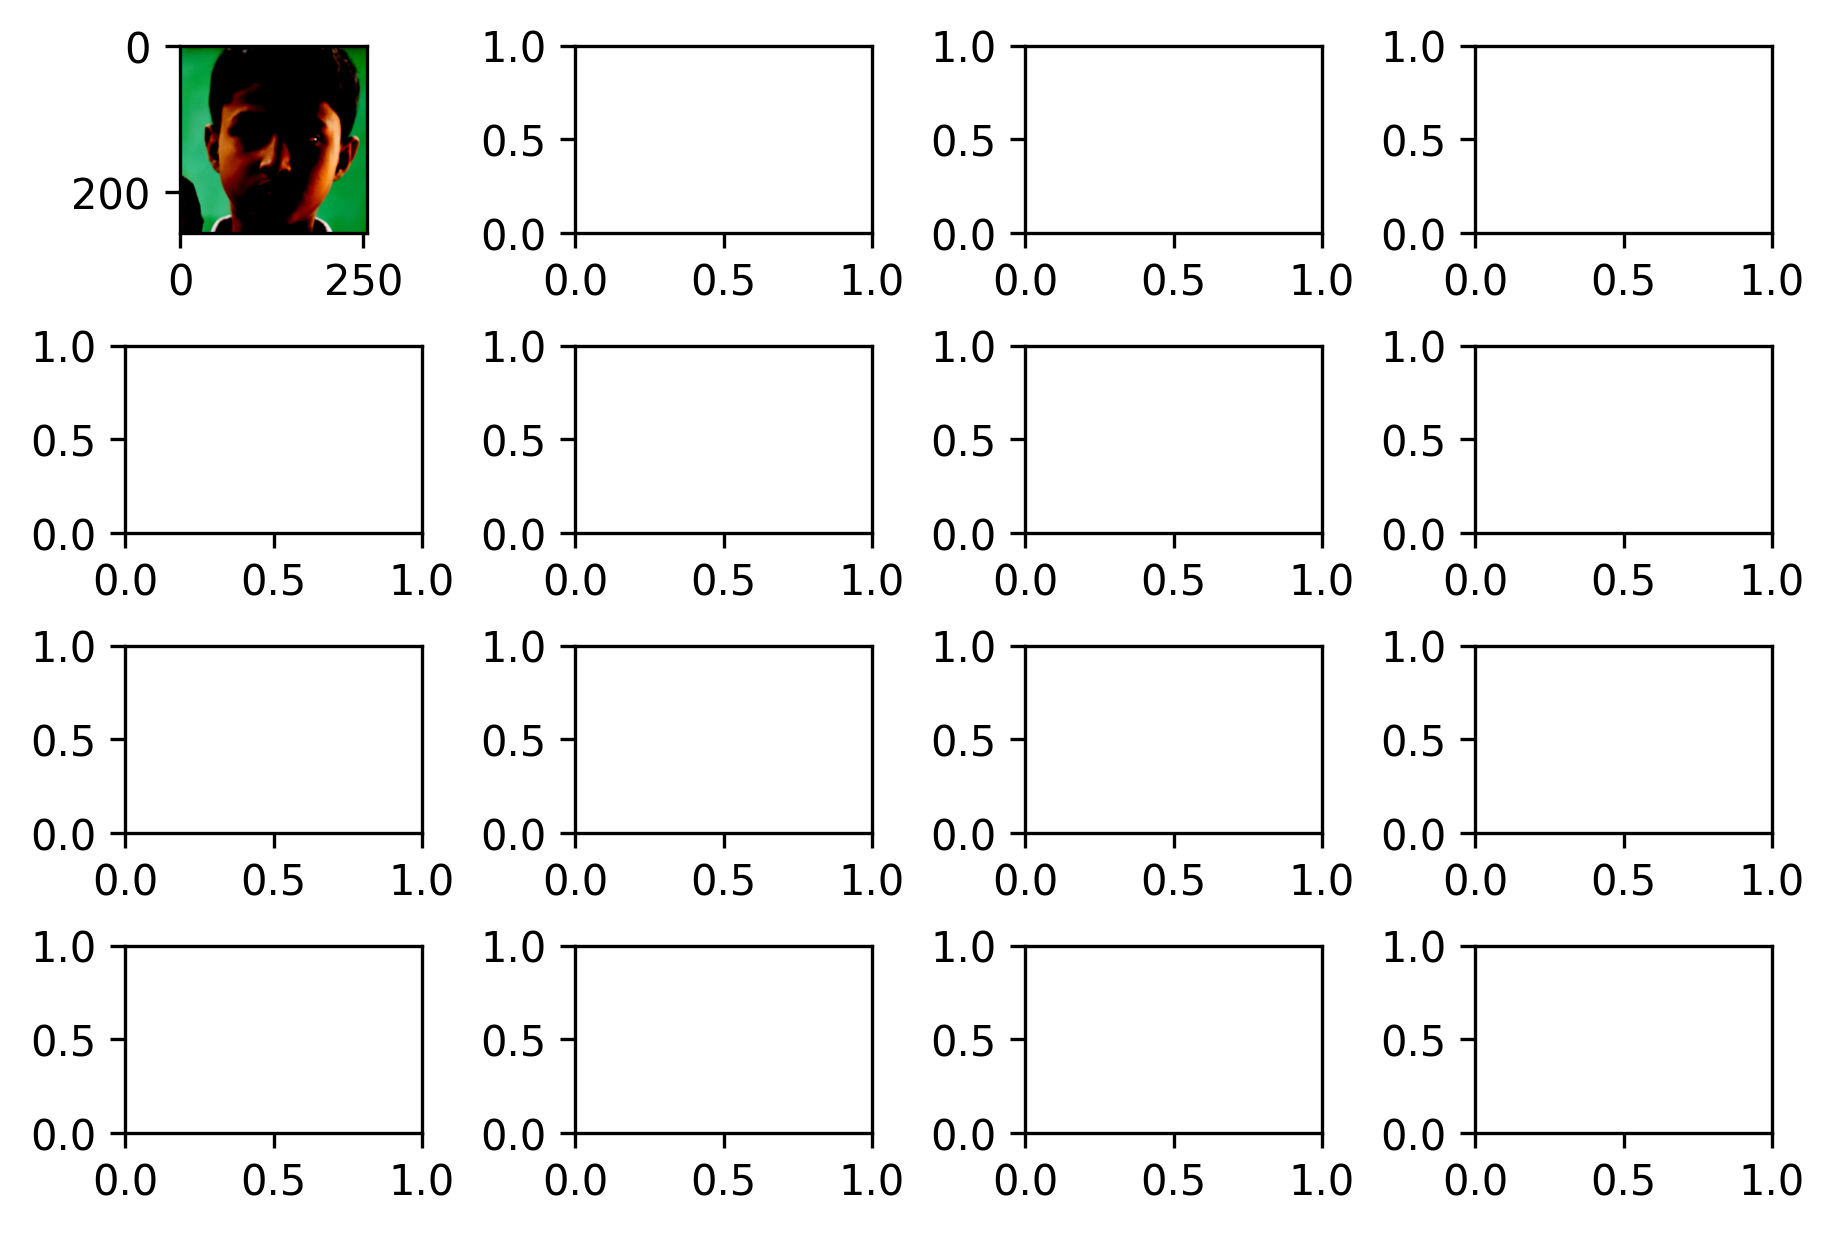

In [19]:
random_nums = [random.randint(0, len(validation_dataset) - 1) for _ in range(batch_size)]
imgs = [validation_dataset[i][0] for i in random_nums]
labls = [validation_dataset[i][1] for i in random_nums]

show_validation(imgs, labls)